# Calculate the distorsion polynomial coefficients

Determines a common model for all test inputs
Outputs the model coefficients

In [1]:
%matplotlib notebook

import sys
import logging
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append("../DesignTool")
from smdtLibs.configFile import ConfigFile, getDefaultConfig
from targets import TargetList
import targets
from smdtLibs.inOutChecker import InOutChecker
from maskDesignFile import (
    MaskDesignInputFitsFile,
    MaskDesignOutputFitsFile,
    outputAsList,
)
from maskLayouts import MaskLayouts, GuiderFOVs, shrinkMask, scaleLayout
from smdtLibs import utils, drawUtils
from astropy.modeling import models, fitting
from diffSlitMask import getTargetPos

import DistortionUtil

from Test_All import Test_Inputs

# from Test_InputM53 import Test_Inputs

In [2]:
try:
    %load_ext nb_black
except:
    print("Ignore extension nb_black")
    pass

<IPython.core.display.Javascript object>

In [3]:
logging.disable()

<IPython.core.display.Javascript object>

## Read the config file and the parameter file

In [4]:
config = getDefaultConfig()

<IPython.core.display.Javascript object>

## The mask layout

In [5]:
layout = MaskLayouts["deimos"]
guiderLayout = GuiderFOVs["deimos"]
layoutMM = scaleLayout(layout, utils.AS2MM, 0, -targets.ZPT_YM)
guiderLayoutMM = scaleLayout(guiderLayout, utils.AS2MM, 0, -targets.ZPT_YM)

<IPython.core.display.Javascript object>

In [6]:
Test_Inputs.keys()

dict_keys(['LeoIa', 'n2419c', 'CetusIII', 'DracoENG', 'dec0Pa0', 'dec0Pa105', 'dec0Pa120', 'dec0Pa135', 'dec0Pa15', 'dec0Pa150', 'dec0Pa165', 'dec0Pa180', 'dec0Pa30', 'dec0Pa45', 'dec0Pa60', 'dec0Pa75', 'dec0Pa90', 'denseNoOverlappingMask', 'NoOverlapPa180L4500', 'NoOverlapPa270L4500', 'NoOverlapPa90L4500', 'denseNoOverlapPa180', 'denseNoOverlapPa270', 'denseNoOverlappingPa90Mask', 'denseOverlappingMask', 'denseOverlappingPa90Mask', 'dec0Pa0_49', 'dec0Pa30_50', 'dec0Pa75_51', 'dec0Pa45_52', 'dec0Pa90_53', 'dec0Pa60_54', 'dec0Pa15_55', 'dec0Pa105_56', 'dec0Pa150_57', 'dec0Pa120_58', 'dec0Pa135_59', 'dec0Pa180_60', 'dec0Pa165_61', 'M53_GAIA_Gmag_le_16_hp4_out', 'M53_GAIA_Gmag_le_16_hp0_out', 'shortPA0', 'shortPA144', 'shortPA216', 'shortPA288', 'shortPA72'])

<IPython.core.display.Javascript object>

In [7]:
def coeffNames(prefix, n):
    """
    Generates coefficient names
    """
    out = [prefix + "00"]
    out.extend([f"{prefix}x{i}y0" for i in range(1, n + 1)])
    out.extend([f"{prefix}x0y{i}" for i in range(1, n + 1)])
    for y in range(1, n):
        for x in range(1, n - y + 1):
            out.append(f"{prefix}x{x}y{y}")
    return out

<IPython.core.display.Javascript object>

In [8]:
# Determines distortion coefficients for enabled input files.
coeffs = []

keys = Test_Inputs.keys()
keys = sorted(keys, key=lambda x: Test_Inputs[x][3])

<IPython.core.display.Javascript object>

In [9]:
len(Test_Inputs)

46

<IPython.core.display.Javascript object>

In [9]:
for k in keys:
    info = Test_Inputs.get(k)
    (input_fname, input_RA, input_DEC, fieldPA, hourAngle, enabled) = info
    if not enabled:
        continue
    print(k)
    try:
        mdf, xfit, yfit, xres, yres = DistortionUtil.calcDistortionCoef(info, config, 2)

    except Exception as e:
        print(k, "failed", e)
        continue

    a = [
        k,
        mdf.maskblu.RefWave[0],
        hourAngle,
        fieldPA,
        xres,
        yres,
    ]  # Reference wavelenght
    # XFit parameters (15)
    pRa, pDec, paDeg = mdf.getPNTCenter()
    a.extend((pRa, pDec))
    a.extend(xfit.parameters)
    # YFit parameters (15)
    a.extend(yfit.parameters)
    coeffs.append(a)
    # print(", ".join([f"{x}" for x in a]))

CetusIII
dec0Pa0
denseNoOverlappingMask
dec0Pa0_49
M53_GAIA_Gmag_le_16_hp4_out
M53_GAIA_Gmag_le_16_hp0_out
shortPA0
dec0Pa15
dec0Pa15_55
dec0Pa30
dec0Pa30_50
dec0Pa45
dec0Pa45_52
n2419c
dec0Pa60
dec0Pa60_54
shortPA72
dec0Pa75
dec0Pa75_51
dec0Pa90
NoOverlapPa90L4500
denseNoOverlappingPa90Mask
dec0Pa90_53
dec0Pa105
dec0Pa105_56
LeoIa
dec0Pa120
dec0Pa120_58
dec0Pa135
dec0Pa135_59
shortPA144
dec0Pa150
dec0Pa150_57
dec0Pa165
dec0Pa165_61
dec0Pa180
NoOverlapPa180L4500
denseNoOverlapPa180
dec0Pa180_60
shortPA216
NoOverlapPa270L4500
denseNoOverlapPa270
shortPA288


<IPython.core.display.Javascript object>

In [12]:
#
# Outputs results
#
colNames = ["Name", "RefWave", "HA", "PA", "Xres", "Yres", "PRA", "PDEC"]
colNames.extend(coeffNames("X_", 2))
colNames.extend(coeffNames("Y_", 2))

coeffsDf = pd.DataFrame(coeffs, columns=colNames)
coeffsDf[
    ["Name", "RefWave", "HA", "PA", "Xres", "Yres", "PRA", "PDEC", "X_x1y0", "Y_x0y1"]
]

,Name,RefWave,HA,PA,Xres,Yres,PRA,PDEC,X_x1y0,Y_x0y1
0,CetusIII,780.0,15.000,-52.0,0.007537,0.009749,31.342009,-4.189464,0.999868,0.999801
1,dec0Pa0,320.0,0.015,0.0,0.004195,0.003096,247.485012,0.914620,0.999612,0.999630
2,denseNoOverlappingMask,750.0,0.000,0.0,3.062762,0.028948,259.956232,57.924169,0.999288,0.999651
3,dec0Pa0_49,320.0,0.015,0.0,0.003841,0.003015,247.455012,0.914620,0.999612,0.999631
4,M53_GAIA_Gmag_le_16_hp4_out,700.0,60.000,0.0,0.002970,0.004156,198.329154,18.169063,0.999628,0.999264
5,M53_GAIA_Gmag_le_16_hp0_out,700.0,0.000,0.0,0.002948,0.004004,198.313527,18.166160,0.999644,0.999636
6,shortPA0,500.0,-30.000,0.0,0.005788,0.008427,114.644047,38.870054,0.999637,0.999609
7,dec0Pa15,320.0,0.015,15.0,0.003933,0.003062,247.482456,0.895208,0.999614,0.999628
8,dec0Pa15_55,320.0,0.015,15.0,0.004055,0.003114,247.452456,0.895208,0.999613,0.999629
9,dec0Pa30,320.0,0.015,30.0,0.005303,0.003841,247.452193,0.871019,0.999617,0.999626


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


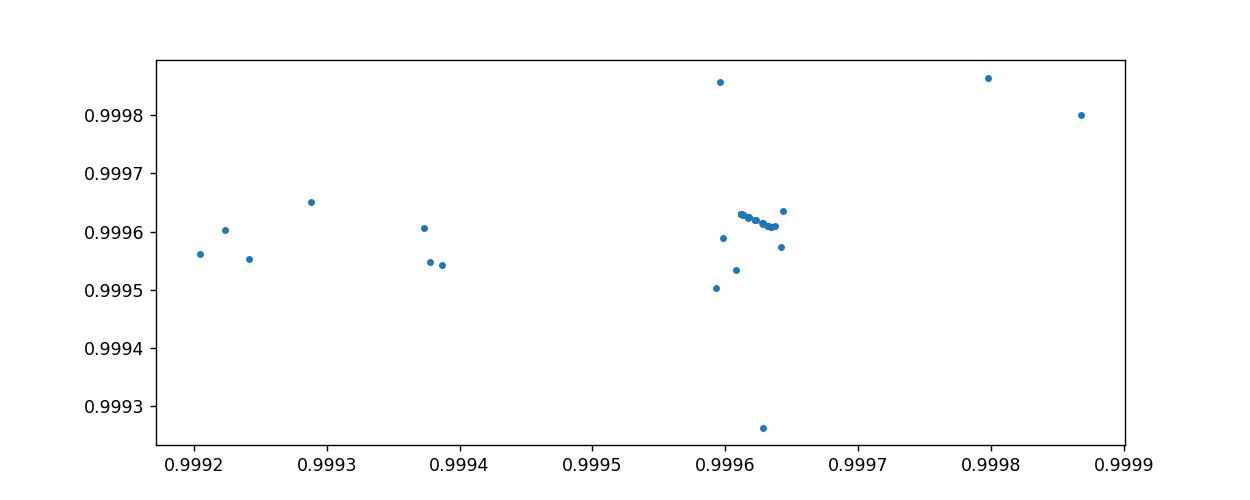

<IPython.core.display.Javascript object>

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(coeffsDf.X_x1y0, coeffsDf.Y_x0y1, ".")
# plt.plot((coeffsDf.PRA - cenRA) * 3600, (coeffsDf.PDEC - cenDEC) * 3600, "+")
# plt.plot(coeffsDf.PRA, coeffsDf.PDEC, "+")

In [20]:
#
# Averages the coefficients
#
startidx = 8
nParams = 6
xs = [f"{coeffsDf[cn].mean()}" for cn in colNames[startidx : startidx + nParams]]
ys = [f"{coeffsDf[cn].mean()}" for cn in colNames[startidx + nParams :]]

with open("coeffs.dat", "w") as fh:
    print('distortionXCoeffs = "', ", ".join(xs), '"', file=fh)
    print('distortionYCoeffs = "', ", ".join(ys), '"', file=fh)
#
# The output should be copied to smdt.cfg
#
!cat coeffs.dat

distortionXCoeffs = " 0.0019400217700955395, 0.9995785056692711, 3.281329690325734e-08, -7.437737193764402e-05, 3.379265004891748e-07, 3.147414541588526e-07 "
distortionYCoeffs = " 0.0003856184442861629, -1.8941203344602475e-06, -7.918751726373506e-10, 0.9996142968894529, 2.386142499802028e-08, 2.3832901023517685e-08 "


<IPython.core.display.Javascript object>

In [15]:
coeffsDf["X_x1y0"].median(), coeffsDf["Y_x0y1"].median()

(0.9996172343164657, 0.9996144232387769)

<IPython.core.display.Javascript object>

In [19]:
coeffNames("", 2)

['00', 'x1y0', 'x2y0', 'x0y1', 'x0y2', 'x1y1']

<IPython.core.display.Javascript object>